# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
from scipy.special import softmax
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE

In [2]:
import vbranch as vb
from vbranch.utils.training_utils import bag_samples

In [3]:
save = False
model_id = 1
architecture = 'fcn'

## Load Data

In [4]:
dataset = 'mnist'
num_classes = 10
num_features = 784
samples_per_class = 100
(X_train, y_train), (X_test, y_test) = vb.utils.get_data(dataset, architecture, num_classes,
                                                         num_features, samples_per_class)

In [5]:
x_shape = (None,) + X_train.shape[1:]
y_shape = (None, num_classes)

## Train

### Build Model

In [6]:
BATCH_SIZE = 32
EPOCHS = 15
STEPS_PER_EPOCH = 100
NUM_BRANCHES = 4
SHARED_FRAC = 0
model_path = os.path.join('models', 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(dataset, architecture,
    NUM_BRANCHES, SHARED_FRAC, model_id))

In [7]:
model_path

'models/vb-mnist-fcn-B4-S0.00_1'

In [8]:
# Perform bagging
x_train_list, y_train_list = bag_samples(X_train, y_train, NUM_BRANCHES, max_samples=0.6)

In [9]:
tf.reset_default_graph()

batch_size = tf.placeholder('int64', name='batch_size')

iterators = [None] * NUM_BRANCHES
inputs = [None] * NUM_BRANCHES
labels_one_hot = [None] * NUM_BRANCHES

x_list = []
y_list = []

for i in range(NUM_BRANCHES):
    x = tf.placeholder('float32', x_shape, name='x_vb{:d}'.format(i+1))
    y = tf.placeholder('float32', y_shape, name='y_vb{:d}'.format(i+1))
    x_list.append(x)
    y_list.append(y)
    
    dataset = tf.data.Dataset.from_tensor_slices((x,y)).\
        repeat().batch(batch_size).shuffle(buffer_size=4*BATCH_SIZE)

    iterators[i] = dataset.make_initializable_iterator()
    inputs[i], labels_one_hot[i] = iterators[i].get_next('input')

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
def build_model(architecture,inputs,labels, num_classes,num_branches,model_id, shared_frac):
    name = 'model_' + str(model_id)
    
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        if architecture == 'fcn':
            model = vb.vbranch_simple_fcn(inputs,
                ([512]*num_branches, int(512*shared_frac)),
                ([num_classes]*num_branches, int(num_classes*shared_frac)),
                branches=num_branches, name=name)
        elif architecture == 'cnn':
            model = vb.vbranch_simple_cnn(inputs, (num_classes, 0),
                ([16]*num_branches, int(16*shared_frac)),
                ([32]*num_branches, int(32*shared_frac)),
                branches=num_branches, name=name)
        else:
            raise ValueError('invalid model')

        if type(labels) is list:
            labels_list = labels
        else:
            labels_list = [labels] * num_branches
            
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        model.compile(optimizer, 'softmax_cross_entropy_with_logits',
                        labels_one_hot=labels_list)

    return model

In [11]:
model = build_model(architecture, inputs, labels_one_hot, num_classes,
        NUM_BRANCHES, model_id, SHARED_FRAC)

Instructions for updating:
Use tf.cast instead.


In [12]:
# Build copy of model for testing
x_place = tf.placeholder('float32', x_shape, name='x_test')
y_place = tf.placeholder('float32', y_shape, name='y_test')

test_model = build_model(architecture, x_place, y_place, num_classes,
    NUM_BRANCHES, model_id, SHARED_FRAC)

### Run Ops

In [13]:
# history = model.fit(iterators, X_train, y_train, EPOCHS, STEPS_PER_EPOCH,
#         BATCH_SIZE, validation=(X_test, y_test), test_model=test_model,
#         save_model_path=model_path)

data_dict = {}

for i in range(NUM_BRANCHES):
    data_dict[x_list[i]] = x_train_list[i]
    data_dict[y_list[i]] = y_train_list[i]
    
history = model.fit_data(iterators, EPOCHS, STEPS_PER_EPOCH, BATCH_SIZE, 
                         data_dict=data_dict, 
                         val_dict={x_place: X_test, y_place: y_test}, 
                         test_model=test_model, save_model_path=model_path)

Epoch 1/15
 - 1s - train_acc_4: 0.8316 - train_loss_1: 0.5585 - train_acc_3: 0.8366 - train_acc_2: 0.8322 - train_loss_2: 0.5270 - train_loss_4: 0.5465 - train_acc_ensemble: 0.3088 - train_loss_3: 0.5054 - train_acc_1: 0.8253 - val_loss_1: 0.2936 - val_acc_ensemble: 0.9350 - val_loss_4: 0.2769 - val_acc_3: 0.9120 - val_loss_2: 0.2811 - val_acc_1: 0.9058 - val_acc_2: 0.9137 - val_acc_4: 0.9164 - val_loss_3: 0.2857
Epoch 2/15
 - 1s - train_acc_4: 0.9328 - train_loss_1: 0.2360 - train_acc_3: 0.9391 - train_acc_2: 0.9291 - train_loss_2: 0.2355 - train_loss_4: 0.2285 - train_acc_ensemble: 0.3356 - train_loss_3: 0.2114 - train_acc_1: 0.9241 - val_loss_1: 0.2260 - val_acc_ensemble: 0.9471 - val_loss_4: 0.2484 - val_acc_3: 0.9304 - val_loss_2: 0.2362 - val_acc_1: 0.9304 - val_acc_2: 0.9279 - val_acc_4: 0.9240 - val_loss_3: 0.2351
Epoch 3/15
 - 1s - train_acc_4: 0.9547 - train_loss_1: 0.1543 - train_acc_3: 0.9587 - train_acc_2: 0.9509 - train_loss_2: 0.1683 - train_loss_4: 0.1510 - train_acc_en

## Load Model

In [15]:
# test_init_ops = ['test_init_op_'+str(i+1) for i in range(NUM_BRANCHES)]
# losses = ['loss_'+str(i+1)+':0' for i in range(NUM_BRANCHES)]
# train_acc_ops = ['train_acc_'+str(i+1)+':0' for i in range(NUM_BRANCHES)]

# inputs = ['input_{}:0'.format(i+1) for i in range(NUM_BRANCHES)]
# labels_one_hot = ['input_{}:1'.format(i+1) for i in range(NUM_BRANCHES)]
outputs = ['model_{}_1/output_vb{}:0'.format(model_id, i+1) for i in range(NUM_BRANCHES)]

In [16]:
with tf.Session() as sess:
    model_path = os.path.join('models', 'vb-mnist-{}-B{:d}-S{:.2f}_{:d}'.format(architecture,
        NUM_BRANCHES, SHARED_FRAC, model_id))
    meta_path = os.path.join(model_path, 'ckpt.meta')
    ckpt = tf.train.get_checkpoint_state(model_path)

    imported_graph = tf.train.import_meta_graph(meta_path)
    imported_graph.restore(sess, ckpt.model_checkpoint_path)

#     sess.run(test_init_ops, feed_dict={'batch_size:0': len(X_test)})
    features = sess.run(outputs, feed_dict={'x_test:0':X_test})
    
#     sample_size = 250
#     sess.run(test_init_ops, feed_dict={'batch_size:0':sample_size})
#     X_test_samples, y_test_samples, features = sess.run([inputs, labels_one_hot, outputs])

INFO:tensorflow:Restoring parameters from models/vb-mnist-cnn-B4-S1.00_1/ckpt


In [17]:
# print('Loss:', np.mean(val_losses))
# print('Acc:', val_acc)
# print('Indiv accs:', indiv_accs)

## Feature Visualization

In [ ]:
mean_features = np.mean(features, axis=0)
print(mean_features.shape)

In [ ]:
start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(mean_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))

In [ ]:
labels = np.argmax(y_test_samples[0], axis=-1)

In [13]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

NameError: name 'tsne_results' is not defined

## Feature Correlation

In [18]:
features = np.array(features)
corr_list = []

for i in range(features.shape[1]):
    corr = np.corrcoef(features[:, i], rowvar=False)
    corr_list.append(corr)

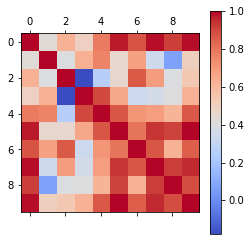

In [24]:
plt.matshow(corr_list[4], cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

In [25]:
corr_list = np.array(corr_list)
mean_corr = np.mean(np.sum(np.square(corr_list), axis=(1,2)) - 10)
print(mean_corr)

37.69674353424667


In [ ]:
0: 30.46930946455603
0.75: 30.68270134409282